In [1]:
"""
ResNet for UDA
"""

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import funcs
import jan
import coral
import star
import mcd
import dann
import base
import plots
import os
import seaborn as sns
import matplotlib.pyplot as plt
from torch.autograd import Function

#%% ResNet block
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        """
        A basic residual block for 1D convolutions.
        """
        super(ResidualBlock1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out += identity
        out = self.relu(out)
        return out

#%% Base
class DeepResNet(nn.Module):
    """
    A deep ResNet classifier for 1D signals.
    
    This network consists of:
      - An initial convolution + BN + ReLU + maxpool block.
      - Four residual layers (with increasing feature channels).
      - Global average pooling to obtain a fixed–length feature vector.
      - A bottleneck fully connected layer mapping to 512–dimensions.
      - A small classifier head (MLP) mapping to the desired output classes.
    """
    def __init__(self, output_dim=7):
        super(DeepResNet, self).__init__()
        # Initial convolutional block
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=64, kernel_size=7,
                               stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        
        # Residual layers
        self.layer1 = self._make_layer(in_channels=64, out_channels=64, blocks=2, stride=1)
        self.layer2 = self._make_layer(in_channels=64, out_channels=128, blocks=2, stride=2)
        self.layer3 = self._make_layer(in_channels=128, out_channels=256, blocks=2, stride=2)
        self.layer4 = self._make_layer(in_channels=256, out_channels=512, blocks=2, stride=2)
        
        # Global average pooling to obtain a fixed-length feature vector
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        # Bottleneck fully-connected layer: maps 512-dim to 512-dim features
        self.fc_bottleneck = nn.Linear(512, 512)
        
        # Classifier head (MLP)
        self.fc1 = nn.Linear(512, 256)
        self.bn_fc = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, output_dim)
        
    def _make_layer(self, in_channels, out_channels, blocks, stride):
        """
        Creates a sequential layer composed of multiple residual blocks.
        If the stride is not 1 or the number of channels change,
        a downsampling layer is used.
        """
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )
        layers = []
        layers.append(ResidualBlock1D(in_channels, out_channels, stride, downsample))
        for _ in range(1, blocks):
            layers.append(ResidualBlock1D(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # x: (batch_size, 2, length)
        x = self.conv1(x)    # (B, 64, L/2)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)  # (B, 64, L/4)
        
        x = self.layer1(x)   # (B, 64, ?)
        x = self.layer2(x)   # (B, 128, ?)
        x = self.layer3(x)   # (B, 256, ?)
        x = self.layer4(x)   # (B, 512, ?)
        
        x = self.avgpool(x)  # (B, 512, 1)
        x = x.squeeze(-1)    # (B, 512)
        x = self.fc_bottleneck(x)  # (B, 512)
        
        # Classification head
        x = self.fc1(x)
        x = self.bn_fc(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

#%% DANN
class GradReverse(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.view_as(x)
    
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.lambda_, None

def grad_reverse(x, lambda_=1.0):
    return GradReverse.apply(x, lambda_)

class DANN_F(nn.Module):
    """
    Deep ResNet feature extractor for DANN.
    
    This network accepts a 2–channel 1D signal and outputs a 512–dimensional feature vector.
    """
    def __init__(self):
        super(DANN_F, self).__init__()
        # Initial convolutional block
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=64, kernel_size=7,
                               stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        
        # Residual layers
        self.layer1 = self._make_layer(in_channels=64, out_channels=64, blocks=2, stride=1)
        self.layer2 = self._make_layer(in_channels=64, out_channels=128, blocks=2, stride=2)
        self.layer3 = self._make_layer(in_channels=128, out_channels=256, blocks=2, stride=2)
        self.layer4 = self._make_layer(in_channels=256, out_channels=512, blocks=2, stride=2)
        
        # Global average pooling to produce a fixed-length vector
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        # Bottleneck fully-connected layer (optional, here keeping feature dim at 512)
        self.fc_bottleneck = nn.Linear(512, 512)
        
    def _make_layer(self, in_channels, out_channels, blocks, stride):
        """
        Create a sequential layer composed of multiple residual blocks.
        """
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )
        layers = []
        layers.append(ResidualBlock1D(in_channels, out_channels, stride, downsample))
        for _ in range(1, blocks):
            layers.append(ResidualBlock1D(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # Input x: (batch_size, channels=2, length)
        x = self.conv1(x)    # -> (B, 64, L/2)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)  # -> (B, 64, L/4)
        
        x = self.layer1(x)   # -> (B, 64, ?)
        x = self.layer2(x)   # -> (B, 128, ?)
        x = self.layer3(x)   # -> (B, 256, ?)
        x = self.layer4(x)   # -> (B, 512, ?)
        
        # Global average pooling
        x = self.avgpool(x)  # -> (B, 512, 1)
        x = x.squeeze(-1)    # -> (B, 512)
        # Bottleneck transformation
        features = self.fc_bottleneck(x)  # (B, 512)
        return features

class DANN_LP(nn.Module):
    """
    Label predictor network that maps 512–dim features to the desired output classes.
    """
    def __init__(self, output_dim=7):
        super(DANN_LP, self).__init__()
        self.fc1 = nn.Linear(512, 256)
        self.bn_fc1 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, output_dim)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class DANN_DC(nn.Module):
    """
    Domain classifier network for DANN.
    
    This network applies a gradient reversal layer (using ReverseLayerF) to the feature vector
    before classifying it as either source or target.
    """
    def __init__(self):
        super(DANN_DC, self).__init__()
        self.fc1 = nn.Linear(512, 100)
        self.fc2 = nn.Linear(100, 2)
        
    def forward(self, x, alpha):
        # Reverse gradient during the backward pass
        x = GradReverse.apply(x, alpha)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#%% CORAL
def coral_loss(source, target):
    """
    Computes the CORAL loss between two matrices.
    Assumes input tensors are of shape (batch_size, feature_dim).
    """
    d = source.size(1)
    ns = source.size(0)
    nt = target.size(0)
    # Center the features
    source_mean = torch.mean(source, dim=0, keepdim=True)
    target_mean = torch.mean(target, dim=0, keepdim=True)
    source_centered = source - source_mean
    target_centered = target - target_mean
    # Compute covariance matrices
    cov_source = (source_centered.t() @ source_centered) / (ns - 1)
    cov_target = (target_centered.t() @ target_centered) / (nt - 1)
    # Frobenius norm between covariance matrices (scaled)
    loss = torch.mean((cov_source - cov_target) ** 2)
    loss = loss / (4 * d * d)
    return loss
        
class CORAL_G(nn.Module):
    """
    Deep ResNet generator that extracts features at multiple depths for CORAL.
    
    Architecture:
      - An initial convolution + batchnorm + ReLU + maxpool.
      - Four layers (residual blocks) built with 1D convolutions.
      - Intermediate features are extracted after layer1 (early), layer2 (middle),
        and layer3 (late) via global average pooling.
      - The final layer (layer4) is pooled and passed through a fully-connected
        bottleneck to obtain a 512–dim feature for classification.
    """
    def __init__(self):
        super(CORAL_G, self).__init__()
        # Initial convolution layer
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=64, kernel_size=7,
                               stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        
        # Residual layers
        self.layer1 = self._make_layer(in_channels=64, out_channels=64, blocks=2, stride=1)
        self.layer2 = self._make_layer(in_channels=64, out_channels=128, blocks=2, stride=2)
        self.layer3 = self._make_layer(in_channels=128, out_channels=256, blocks=2, stride=2)
        self.layer4 = self._make_layer(in_channels=256, out_channels=512, blocks=2, stride=2)
        
        # Global average pooling (adaptive to any sequence length)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        # Bottleneck fully-connected layer mapping 512->512 for classification.
        self.fc_bottleneck = nn.Linear(512, 512)
        
    def _make_layer(self, in_channels, out_channels, blocks, stride):
        """
        Creates a sequential layer composed of multiple residual blocks.
        If the stride is not 1 or the channel dimensions differ,
        a downsampling layer is used.
        """
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )
        layers = []
        layers.append(ResidualBlock1D(in_channels, out_channels, stride, downsample))
        for _ in range(1, blocks):
            layers.append(ResidualBlock1D(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # Input x: (batch_size, channels=2, length)
        x = self.conv1(x)   # (B, 64, L/2)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x) # (B, 64, L/4)
        
        # Layer 1: Early features
        x1 = self.layer1(x)           # (B, 64, L1)
        early = self.avgpool(x1)      # (B, 64, 1)
        early = early.squeeze(-1)     # (B, 64)
        
        # Layer 2: Middle features
        x2 = self.layer2(x1)          # (B, 128, L2)
        middle = self.avgpool(x2)     # (B, 128, 1)
        middle = middle.squeeze(-1)   # (B, 128)
        
        # Layer 3: Late features for CORAL loss
        x3 = self.layer3(x2)          # (B, 256, L3)
        late = self.avgpool(x3)       # (B, 256, 1)
        late = late.squeeze(-1)       # (B, 256)
        
        # Layer 4: Final block for classification
        x4 = self.layer4(x3)          # (B, 512, L4)
        pooled = self.avgpool(x4)     # (B, 512, 1)
        pooled = pooled.squeeze(-1)   # (B, 512)
        final = self.fc_bottleneck(pooled)  # (B, 512)
        
        # Return multi-level features for deep CORAL
        return early, middle, late, final

class CORAL_C(nn.Module):
    """
    Classifier network that maps the 512–dim bottleneck features to the output classes.
    
    Architecture:
      - A fully-connected layer (512 -> 256) with batch normalization, ReLU, and dropout.
      - A final fully-connected layer mapping 256 -> output_dim.
    """
    def __init__(self, output_dim):
        super(CORAL_C, self).__init__()
        self.fc1 = nn.Linear(512, 256)
        self.bn_fc1 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, output_dim)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


class DeepCORAL:
    def __init__(self, G, C, device, 
                 S_train_loader, S_val_loader, 
                 T_train_loader, T_val_loader,
                 class_subset, n_classes, lr, n_epochs, n_runs, patience, 
                 lambda_coral=0.5, deep_weights=(1.0, 1.0, 1.0)):
        """
        deep_weights: tuple of weights for the CORAL loss at (early, middle, late) layers.
        """
        self.G = G
        self.C = C
        self.device = device
        self.S_train_loader = S_train_loader
        self.S_val_loader = S_val_loader
        self.T_train_loader = T_train_loader
        self.T_val_loader = T_val_loader
        self.class_subset = class_subset
        self.n_classes = n_classes
        self.lr = lr
        self.n_epochs = n_epochs
        self.n_runs = n_runs
        self.patience = patience
        self.lambda_coral = lambda_coral
        self.deep_weights = deep_weights
        
    def evaluate(self, netG, netC, loader):
        netG.eval()
        netC.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, labels in loader:
                data, labels = data.to(self.device), labels.to(self.device)
                # Only need the classification branch (late_fc)
                _, _, _, cls_feat = netG(data)
                outputs = netC(cls_feat)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        return correct / total

    def run(self):
        best_s_acc_list = []
        best_t_acc_list = []
        for run in range(self.n_runs):
            print(f"Deep CORAL Run {run+1}/{self.n_runs}")
            # Instantiate new networks for each run
            netG = self.G().to(self.device)
            netC = self.C(self.n_classes).to(self.device)
            optimizer = torch.optim.Adam(list(netG.parameters()) + list(netC.parameters()), lr=self.lr)
            criterion = nn.CrossEntropyLoss()
            best_val_acc = 0.0
            patience_counter = 0
            
            for epoch in range(self.n_epochs):
                netG.train()
                netC.train()
                # Use zip to iterate over source and target batches in parallel.
                for (s_data, s_labels), (t_data, _) in zip(self.S_train_loader, self.T_train_loader):
                    s_data, s_labels = s_data.to(self.device), s_labels.to(self.device)
                    t_data = t_data.to(self.device)
                    
                    # Forward pass for source: get all features
                    s_early, s_middle, s_late, s_cls = netG(s_data)
                    # Classification loss on source (using the classification feature)
                    loss_cls = criterion(netC(s_cls), s_labels)
                    
                    # Forward pass for target: we only need the intermediate features
                    t_early, t_middle, t_late, _ = netG(t_data)
                    
                    # Compute CORAL loss for each level
                    loss_early = coral_loss(s_early, t_early)
                    loss_middle = coral_loss(s_middle, t_middle)
                    loss_late = coral_loss(s_late, t_late)
                    loss_coral_total = (self.deep_weights[0] * loss_early +
                                        self.deep_weights[1] * loss_middle +
                                        self.deep_weights[2] * loss_late)
                    
                    total_loss = loss_cls + self.lambda_coral * loss_coral_total
                    
                    optimizer.zero_grad()
                    total_loss.backward()
                    optimizer.step()
                    
                # End-of-epoch evaluation on source validation set
                s_acc = self.evaluate(netG, netC, self.S_val_loader)
                t_acc = self.evaluate(netG, netC, self.T_val_loader)
                print(f"Epoch {epoch+1}: Source Val Acc = {s_acc:.4f}, Target Val Acc = {t_acc:.4f}")
                
                # Early stopping on source validation accuracy
                if s_acc > best_val_acc:
                    best_val_acc = s_acc
                    best_model_G = netG.state_dict()
                    best_model_C = netC.state_dict()
                    patience_counter = 0
                else:
                    patience_counter += 1
                if patience_counter >= self.patience:
                    print("Early stopping triggered.")
                    break
                    
            # Load best model from this run
            netG.load_state_dict(best_model_G)
            netC.load_state_dict(best_model_C)
            s_acc = self.evaluate(netG, netC, self.S_val_loader)
            t_acc = self.evaluate(netG, netC, self.T_val_loader)
            print(f"Run {run+1} finished: Best Source Val Acc = {s_acc:.4f}, Target Val Acc = {t_acc:.4f}\n")
            best_s_acc_list.append(s_acc)
            best_t_acc_list.append(t_acc)
            
        avg_s_acc = np.mean(best_s_acc_list)
        avg_t_acc = np.mean(best_t_acc_list)
        print(f"Deep CORAL: Average Source Val Acc = {avg_s_acc:.4f}, Average Target Val Acc = {avg_t_acc:.4f}")
        return avg_s_acc, avg_t_acc

#%% STAR
class STAR_G(nn.Module):
    """
    Deep ResNet feature extractor for STAR.
    
    This network accepts a 2–channel 1D signal and extracts a 512–dimensional
    feature vector via several residual layers.
    """
    def __init__(self):
        super(STAR_G, self).__init__()
        # Initial convolutional block
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=64, kernel_size=7,
                               stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        
        # Residual layers
        self.layer1 = self._make_layer(64, 64, blocks=2, stride=1)
        self.layer2 = self._make_layer(64, 128, blocks=2, stride=2)
        self.layer3 = self._make_layer(128, 256, blocks=2, stride=2)
        self.layer4 = self._make_layer(256, 512, blocks=2, stride=2)
        
        # Global average pooling to obtain a fixed-length feature vector
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        # Optional bottleneck fully-connected layer (maps 512->512)
        self.fc_bottleneck = nn.Linear(512, 512)
        
    def _make_layer(self, in_channels, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )
        layers = []
        layers.append(ResidualBlock1D(in_channels, out_channels, stride, downsample))
        for _ in range(1, blocks):
            layers.append(ResidualBlock1D(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # x: (batch_size, channels=2, length)
        x = self.conv1(x)      # (B, 64, L/2)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)    # (B, 64, L/4)
        
        x = self.layer1(x)     # (B, 64, ?)
        x = self.layer2(x)     # (B, 128, ?)
        x = self.layer3(x)     # (B, 256, ?)
        x = self.layer4(x)     # (B, 512, ?)
        
        x = self.avgpool(x)    # (B, 512, 1)
        x = x.squeeze(-1)      # (B, 512)
        x = self.fc_bottleneck(x)  # (B, 512)
        return x

class STAR_C(nn.Module):
    """
    Stochastic classifier network for STAR.
    
    This network receives the 512–dim features from DeepResNet_STAR_G,
    applies a fully connected layer with batch normalization and ReLU,
    and then uses a learned weight distribution (mu2, sigma2) to sample
    classifier weights. During training, it samples num_classifiers_train classifiers,
    while during evaluation it can either use only the mean (only_mu=True) or
    sample num_classifiers_test classifiers.
    """
    def __init__(self, output_dim, num_classifiers_train=2, num_classifiers_test=20,
                 init='kaiming_u', use_init=False):
        super(STAR_C, self).__init__()
        self.num_classifiers_train = num_classifiers_train
        self.num_classifiers_test = num_classifiers_test
        self.init = init

        function_init = {
            'kaiming_u': nn.init.kaiming_uniform_,
            'kaiming_n': nn.init.kaiming_normal_,
            'xavier': nn.init.xavier_normal_
        }

        # Change input dimension to 512 (from the DeepResNet feature extractor)
        self.fc1 = nn.Linear(512, 128)
        self.bn1_fc = nn.BatchNorm1d(128)

        # Learnable parameters for the classifier weight distribution
        self.mu2 = nn.Parameter(torch.randn(output_dim, 128))
        self.sigma2 = nn.Parameter(torch.zeros(output_dim, 128))

        if use_init:
            for item in [self.mu2, self.sigma2]:
                function_init[self.init](item)

        self.b2 = nn.Parameter(torch.zeros(output_dim))

    def forward(self, x, only_mu=True):
        x = self.fc1(x)
        x = F.relu(self.bn1_fc(x))

        sigma2_pos = torch.sigmoid(self.sigma2)
        fc2_distribution = torch.distributions.Normal(self.mu2, sigma2_pos)

        if self.training:
            classifiers = []
            for _ in range(self.num_classifiers_train):
                fc2_w = fc2_distribution.rsample()
                classifiers.append([fc2_w, self.b2])

            outputs = []
            for classifier in classifiers:
                out = F.linear(x, classifier[0], classifier[1])
                outputs.append(out)
            return outputs
        else:
            if only_mu:
                out = F.linear(x, self.mu2, self.b2)
                return [out]
            else:
                classifiers = []
                for _ in range(self.num_classifiers_test):
                    fc2_w = fc2_distribution.rsample()
                    classifiers.append([fc2_w, self.b2])
                outputs = []
                for classifier in classifiers:
                    out = F.linear(x, classifier[0], classifier[1])
                    outputs.append(out)
                return outputs

#%% MCD
class MCD_G(nn.Module):
    def __init__(self):
        super(MCD_G, self).__init__()
        # Initial convolutional block
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=64, kernel_size=7,
                               stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        
        # Residual layers
        self.layer1 = self._make_layer(in_channels=64, out_channels=64, blocks=2, stride=1)
        self.layer2 = self._make_layer(in_channels=64, out_channels=128, blocks=2, stride=2)
        self.layer3 = self._make_layer(in_channels=128, out_channels=256, blocks=2, stride=2)
        self.layer4 = self._make_layer(in_channels=256, out_channels=512, blocks=2, stride=2)
        
        # Global average pooling to get a fixed-length feature vector
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        # Bottleneck fully-connected layer mapping 512 -> 512 (optional)
        self.fc_bottleneck = nn.Linear(512, 512)
        
    def _make_layer(self, in_channels, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )
        layers = []
        layers.append(ResidualBlock1D(in_channels, out_channels, stride, downsample))
        for _ in range(1, blocks):
            layers.append(ResidualBlock1D(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # Input x shape: (batch_size, 2, length)
        x = self.conv1(x)      # -> (B, 64, L/2)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)    # -> (B, 64, L/4)
        
        x = self.layer1(x)     # -> (B, 64, ?)
        x = self.layer2(x)     # -> (B, 128, ?)
        x = self.layer3(x)     # -> (B, 256, ?)
        x = self.layer4(x)     # -> (B, 512, ?)
        
        x = self.avgpool(x)    # -> (B, 512, 1)
        x = x.squeeze(-1)      # -> (B, 512)
        x = self.fc_bottleneck(x)  # -> (B, 512)
        return x

class MCD_C(nn.Module):
    def __init__(self, output_dim):
        super(MCD_C, self).__init__()
        # Since our feature extractor now outputs a 512-dim vector,
        # adjust the input dimension accordingly.
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, output_dim)
    
    def forward(self, x, reverse=False, lambda_=1.0):
        # Optionally apply gradient reversal
        if reverse:
            x = grad_reverse(x, lambda_)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#%% JAN
class JAN_G(nn.Module):
    def __init__(self):
        super(JAN_G, self).__init__()
        # Initial convolutional block
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=64, kernel_size=7,
                               stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        
        # Residual layers
        self.layer1 = self._make_layer(64, 64, blocks=2, stride=1)
        self.layer2 = self._make_layer(64, 128, blocks=2, stride=2)
        self.layer3 = self._make_layer(128, 256, blocks=2, stride=2)
        self.layer4 = self._make_layer(256, 512, blocks=2, stride=2)
        
        # Global average pooling to obtain a fixed-length feature vector
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        # Bottleneck layer mapping 512 -> 512 dimensions
        self.fc_bottleneck = nn.Linear(512, 512)
    
    def _make_layer(self, in_channels, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )
        layers = []
        layers.append(ResidualBlock1D(in_channels, out_channels, stride, downsample))
        for _ in range(1, blocks):
            layers.append(ResidualBlock1D(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # x: (batch_size, 2, length)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)  # shape: (batch, 512, 1)
        x = x.squeeze(-1)    # shape: (batch, 512)
        x = self.fc_bottleneck(x)  # shape: (batch, 512)
        
        # Debug: Ensure x is a valid tensor
        if x is None:
            raise ValueError("Generator output is None. Check your forward pass.")
        # You can also uncomment the next line to print the shape during debugging.
        # print("Generator output shape:", x.shape)
        return x

class C_JAN(nn.Module):
    def __init__(self, output_dim):
        super(C_JAN, self).__init__()
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, output_dim)
        
    def forward(self, x, return_intermediate=False):
        inter = torch.relu(self.fc1(x))
        out = self.fc2(inter)
        if return_intermediate:
            return out, inter
        else:
            return out

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
file_path = "/home/ash/ic3/testbed_da/data"

# Classes in loaded npy files
class_subset = ["bpsk", "qpsk", "16qam", "8apsk"]

# simulated data
X_sim = np.load(file_path + "/sim_X.npy")
Y_sim = np.load(file_path + "/sim_Y.npy")

# over the air data
X_ota = np.load(file_path + "/ota_X.npy")
Y_ota = np.load(file_path + "/ota_Y.npy")

z_val = 10
n_epochs = 50
lr = 0.001
n_runs = 3
n_snr = 4

# (Lists for storing accuracies; you may also want to add lists for deep coral)
t_deep_coral_acc = []
t_base_acc = []
t_dann_acc = []
t_mcd_acc = []
t_star_acc = []
t_jan_acc = []

for i in range(n_snr):
    print(f'\nSNR level: {z_val}')
    # Filter for SNR level (for simulated data)
    source_mask = (Y_sim[:, 1] == z_val)
    X_s = X_sim[source_mask]
    Y_s = Y_sim[source_mask]
    Y_s = Y_s[:, 0]  # first column: class labels

    # Filter for SNR level (for over the air data)
    source_mask = (Y_ota[:, 1] == z_val+4)
    X_t = X_ota[source_mask]
    Y_t = Y_ota[source_mask]
    Y_t = Y_t[:, 0]
    
    # Create data loaders
    S_train_loader, S_val_loader = funcs.create_loader(X_s, Y_s, batch_size=128, permute=False)
    T_train_loader, T_val_loader = funcs.create_loader(X_t, Y_t, batch_size=128, permute=False)

    print('Base')
    _, t_base = base.Base(
        model_cls=DeepResNet,
        device=device,
        S_train_loader=S_train_loader, 
        S_val_loader=S_val_loader,
        T_val_loader=T_val_loader,
        class_subset=class_subset, 
        n_classes=len(class_subset),
        lr=lr,
        n_epochs=n_epochs,
        n_runs=n_runs
    ).run()
    torch.cuda.empty_cache()
    #s_deep_coral_acc.append(s_deep)
    t_base_acc.append(t_base)

    print('DANN')
    _, t_dann = dann.DAN(
        dann.DANN,
        FA=DANN_F,
        LP=DANN_LP,
        DC=DANN_DC,
        device=device,
        S_train_loader=S_train_loader,
        S_val_loader=S_val_loader,
        T_train_loader=T_train_loader,
        T_val_loader=T_val_loader,
        class_subset=class_subset,
        n_classes=len(class_subset),
        lr=lr,
        n_epochs=n_epochs,
        n_runs=n_runs
    ).run()
    torch.cuda.empty_cache()
    #s_deep_coral_acc.append(s_deep)
    t_dann_acc.append(t_dann)

    print('Deep CORAL')
    _, t_deep = DeepCORAL(
        G=CORAL_G, 
        C=CORAL_C, 
        device=device, 
        S_train_loader=S_train_loader,
        S_val_loader=S_val_loader,
        T_train_loader=T_train_loader,
        T_val_loader=T_val_loader,
        class_subset=class_subset,
        n_classes=len(class_subset),
        lr=lr, 
        n_epochs=n_epochs, 
        n_runs=n_runs,
        patience=5,
        lambda_coral=0.5,
        deep_weights=(1.0, 1.0, 1.0)
    ).run()
    torch.cuda.empty_cache()
    #s_deep_coral_acc.append(s_deep)
    t_deep_coral_acc.append(t_deep)

    print('STAR')
    _, t_star =  star.Star(
        G=STAR_G,
        C=STAR_C,
        device=device,
        S_train_loader=S_train_loader,
        S_val_loader=S_val_loader,  
        T_train_loader=T_train_loader,
        T_val_loader=T_val_loader,
        class_subset=class_subset,
        n_classes=len(class_subset),
        lr=lr,
        n_epochs=n_epochs,
        n_runs=n_runs,
        patience=5
    ).run()
    torch.cuda.empty_cache()
    #s_deep_coral_acc.append(s_deep)
    t_star_acc.append(t_star)

    print('MCD')
    _, t_mcd = mcd.Mcd(
        G=MCD_G,
        C=MCD_C,
        device=device,
        S_train_loader=S_train_loader,
        S_val_loader=S_val_loader,  
        T_train_loader=T_train_loader,
        T_val_loader=T_val_loader,
        class_subset=class_subset,
        n_classes=len(class_subset),
        lr=lr,
        n_epochs=n_epochs,
        n_runs=n_runs,
        patience=5
    ).run()
    torch.cuda.empty_cache()
    #s_deep_coral_acc.append(s_deep)
    t_mcd_acc.append(t_mcd)

    print('JAN')
    _, t_jan = jan.Jan(
        C=C_JAN,
        G=JAN_G,
        num_classes=len(class_subset),
        device=device,
        S_train_loader=S_train_loader,
        T_train_loader=T_train_loader,
        S_val_loader=S_val_loader,
        T_val_loader=T_val_loader,
        n_epochs=n_epochs,
        lr=lr,
        lambda_jmmd=0.1,
        n_runs=n_runs
    ).run()
    torch.cuda.empty_cache()
    #s_deep_coral_acc.append(s_deep)
    t_jan_acc.append(t_jan)

    

    z_val += 4


SNR level: 10
Base

Run 1/3
Epoch 1/50, Train Loss: 0.2876, Train Acc: 0.8988, Val Loss: 0.6662, Val Acc: 0.7410
Epoch 2/50, Train Loss: 0.0394, Train Acc: 0.9882, Val Loss: 1.8437, Val Acc: 0.6379
Epoch 3/50, Train Loss: 0.0192, Train Acc: 0.9945, Val Loss: 0.0091, Val Acc: 0.9982
Epoch 4/50, Train Loss: 0.0216, Train Acc: 0.9936, Val Loss: 0.2437, Val Acc: 0.9155
Epoch 5/50, Train Loss: 0.0227, Train Acc: 0.9927, Val Loss: 0.0123, Val Acc: 0.9952
Epoch 6/50, Train Loss: 0.0147, Train Acc: 0.9963, Val Loss: 0.0078, Val Acc: 0.9970
Epoch 7/50, Train Loss: 0.0213, Train Acc: 0.9937, Val Loss: 1.5503, Val Acc: 0.7116
Epoch 8/50, Train Loss: 0.0111, Train Acc: 0.9981, Val Loss: 0.0255, Val Acc: 0.9904
Epoch 9/50, Train Loss: 0.0109, Train Acc: 0.9975, Val Loss: 2.2404, Val Acc: 0.6553
Epoch 10/50, Train Loss: 0.0067, Train Acc: 0.9982, Val Loss: 0.0080, Val Acc: 0.9976
Epoch 11/50, Train Loss: 0.0017, Train Acc: 0.9997, Val Loss: 0.0029, Val Acc: 0.9982
Epoch 12/50, Train Loss: 0.0013, T

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 0.4289, Train Acc: 0.8302, Val Loss: 3.5411, Val Acc: 0.5366
Epoch 2/50, Train Loss: 0.1194, Train Acc: 0.9573, Val Loss: 0.1552, Val Acc: 0.9376
Epoch 3/50, Train Loss: 0.0637, Train Acc: 0.9781, Val Loss: 0.0546, Val Acc: 0.9760
Epoch 4/50, Train Loss: 0.0257, Train Acc: 0.9913, Val Loss: 0.1012, Val Acc: 0.9640
Epoch 5/50, Train Loss: 0.0349, Train Acc: 0.9894, Val Loss: 0.6453, Val Acc: 0.8771
Epoch 6/50, Train Loss: 0.0216, Train Acc: 0.9919, Val Loss: 3.8161, Val Acc: 0.7494
Epoch 7/50, Train Loss: 0.0178, Train Acc: 0.9943, Val Loss: 2.2634, Val Acc: 0.6439
Epoch 8/50, Train Loss: 0.0121, Train Acc: 0.9972, Val Loss: 0.0194, Val Acc: 0.9946
Epoch 9/50, Train Loss: 0.0078, Train Acc: 0.9976, Val Loss: 0.8892, Val Acc: 0.8034
Epoch 10/50, Train Loss: 0.0047, Train Acc: 0.9984, Val Loss: 0.5071, Val Acc: 0.8891
Epoch 11/50, Train Loss: 0.0033, Train Acc: 0.9991, Val Loss: 0.0038, Val Acc: 0.9988
Epoch 12/50, Train Loss: 0.0015, Train Acc: 0.9999, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Loss: 2.2300, Domain Loss: 1.3667, Class Loss: 0.8634
Epoch 2/50, Loss: 1.6555, Domain Loss: 1.2364, Class Loss: 0.4191
Epoch 3/50, Loss: 1.9736, Domain Loss: 1.6258, Class Loss: 0.3478
Epoch 4/50, Loss: 2.1640, Domain Loss: 1.8500, Class Loss: 0.3140
Epoch 5/50, Loss: 7.1205, Domain Loss: 6.6877, Class Loss: 0.4328
Epoch 6/50, Loss: 7.6948, Domain Loss: 6.6647, Class Loss: 1.0301
Epoch 7/50, Loss: 5.7883, Domain Loss: 5.3354, Class Loss: 0.4529
Epoch 8/50, Loss: 6.4265, Domain Loss: 6.0454, Class Loss: 0.3811
Epoch 9/50, Loss: 2.2409, Domain Loss: 1.8259, Class Loss: 0.4150
Epoch 10/50, Loss: 2.0155, Domain Loss: 1.6981, Class Loss: 0.3174
Epoch 11/50, Loss: 2.1387, Domain Loss: 1.8213, Class Loss: 0.3175
Epoch 12/50, Loss: 3.3505, Domain Loss: 2.7767, Class Loss: 0.5737
Epoch 13/50, Loss: 4.9954, Domain Loss: 4.3333, Class Loss: 0.6622
Epoch 14/50, Loss: 2.4752, Domain Loss: 2.1135, Class Loss: 0.3617
Epoch 15/50, Loss: 2.3101, Domain Loss: 1.9805, Class Loss: 0.3296
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1: Source Val Acc = 0.8129, Target Val Acc = 0.4838
Epoch 2: Source Val Acc = 0.7740, Target Val Acc = 0.5713
Epoch 3: Source Val Acc = 0.7392, Target Val Acc = 0.4826
Epoch 4: Source Val Acc = 0.9748, Target Val Acc = 0.6433
Epoch 5: Source Val Acc = 0.8831, Target Val Acc = 0.7794
Epoch 6: Source Val Acc = 0.5132, Target Val Acc = 0.4940
Epoch 7: Source Val Acc = 0.9928, Target Val Acc = 0.8585
Epoch 8: Source Val Acc = 0.9844, Target Val Acc = 0.7944
Epoch 9: Source Val Acc = 0.9826, Target Val Acc = 0.7986
Epoch 10: Source Val Acc = 0.9958, Target Val Acc = 0.9167
Epoch 11: Source Val Acc = 0.9928, Target Val Acc = 0.9323
Epoch 12: Source Val Acc = 0.9994, Target Val Acc = 0.9293
Epoch 13: Source Val Acc = 0.9988, Target Val Acc = 0.8537
Epoch 14: Source Val Acc = 0.8046, Target Val Acc = 0.5815
Epoch 15: Source Val Acc = 0.9928, Target Val Acc = 0.7680
Epoch 16: Source Val Acc = 0.9976, Target Val Acc = 0.9191
Epoch 17: Source Val Acc = 0.9874, Target Val Acc = 0.8393
Early 

4
4


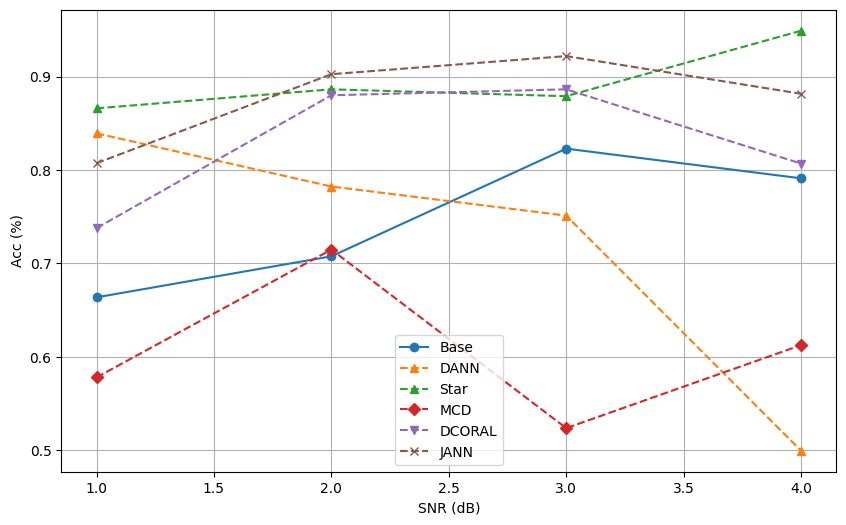

In [3]:
x = np.arange(1, n_snr+1)
print(len(t_deep_coral_acc))
print(len(x))

plt.figure(figsize=(10, 6))
plt.plot(x, t_base_acc, marker='o', linestyle='-', label='Base')
plt.plot(x, t_dann_acc, marker='^', linestyle='--', label='DANN')
plt.plot(x, t_star_acc, marker='^', linestyle='--', label='Star')
plt.plot(x, t_mcd_acc, marker='D', linestyle='--', label='MCD')
plt.plot(x, t_deep_coral_acc, marker='v', linestyle='--', label='DCORAL')
plt.plot(x, t_jan_acc, marker='x', linestyle='--', label='JANN')

plt.xlabel('SNR (dB)')
plt.ylabel('Acc (%)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
"""
Resnet for DANN.
"""

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
file_path = "/home/ash/ic3/testbed_da/data"

# Classes in loaded npy files
class_subset = ["bpsk", "qpsk", "16qam", "8apsk"]

# simulated data
X_sim = np.load(file_path + "/sim_X.npy")
Y_sim = np.load(file_path + "/sim_Y.npy")

# over the air data
X_ota = np.load(file_path + "/ota_X.npy")
Y_ota = np.load(file_path + "/ota_Y.npy")

z_val = 10
n_epochs = 50
lr = 0.001
n_runs = 5
n_snr = 4

# (Lists for storing accuracies; you may also want to add lists for deep coral)
t_deep_coral_acc = []
s_deep_coral_acc = []

for i in range(n_snr):
    print(f'\nSNR level: {z_val}')
    # Filter for SNR level (for simulated data)
    source_mask = (Y_sim[:, 1] == z_val)
    X_s = X_sim[source_mask]
    Y_s = Y_sim[source_mask]
    Y_s = Y_s[:, 0]  # first column: class labels

    # Filter for SNR level (for over the air data)
    source_mask = (Y_ota[:, 1] == z_val+4)
    X_t = X_ota[source_mask]
    Y_t = Y_ota[source_mask]
    Y_t = Y_t[:, 0]
    
    # Create data loaders
    S_train_loader, S_val_loader = funcs.create_loader(X_s, Y_s, batch_size=128, permute=False)
    T_train_loader, T_val_loader = funcs.create_loader(X_t, Y_t, batch_size=128, permute=False)

    z_val += 4

x = np.arange(1, n_snr+1)
print(len(t_deep_coral_acc))
print(len(x))

plt.figure(figsize=(10, 6))
#plt.plot(x, t_base_acc, marker='o', linestyle='-', label='Base')
#plt.plot(x, s_dann_acc, marker='v', linestyle='-', label='Source')
#plt.plot(x, t_dann_acc, marker='^', linestyle='-', label='Target')
#plt.plot(x, t_star_acc, marker='^', linestyle='--', label='Star')
#plt.plot(x, t_mcd_acc, marker='D', linestyle='--', label='MCD')
plt.plot(x, t_deep_coral_acc, marker='v', linestyle='-', label='Target')
plt.plot(x, s_deep_coral_acc, marker='^', linestyle='-', label='Source')
#plt.plot(x, t_jan_acc, marker='x', linestyle='--', label='JANN')

plt.xlabel('SNR (dB)')
plt.ylabel('Acc (%)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
"""
Deep CORAL + ResNet.
"""

# -------------------------
# Data loading (same as before)
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
file_path = "/home/ash/ic3/testbed_da/data"

# Classes in loaded npy files
class_subset = ["bpsk", "qpsk", "16qam", "8apsk"]

# simulated data
X_sim = np.load(file_path + "/sim_X.npy")
Y_sim = np.load(file_path + "/sim_Y.npy")

# over the air data
X_ota = np.load(file_path + "/ota_X.npy")
Y_ota = np.load(file_path + "/ota_Y.npy")

z_val = 10
n_epochs = 50
lr = 0.001
n_runs = 5
n_snr = 4

# (Lists for storing accuracies; you may also want to add lists for deep coral)
t_deep_coral_acc = []
s_deep_coral_acc = []

for i in range(n_snr):
    print(f'\nSNR level: {z_val}')
    # Filter for SNR level (for simulated data)
    source_mask = (Y_sim[:, 1] == z_val)
    X_s = X_sim[source_mask]
    Y_s = Y_sim[source_mask]
    Y_s = Y_s[:, 0]  # first column: class labels

    # Filter for SNR level (for over the air data)
    source_mask = (Y_ota[:, 1] == z_val+4)
    X_t = X_ota[source_mask]
    Y_t = Y_ota[source_mask]
    Y_t = Y_t[:, 0]
    
    # Create data loaders
    S_train_loader, S_val_loader = funcs.create_loader(X_s, Y_s, batch_size=128, permute=False)
    T_train_loader, T_val_loader = funcs.create_loader(X_t, Y_t, batch_size=128, permute=False)

    z_val += 4

x = np.arange(1, n_snr+1)
print(len(t_deep_coral_acc))
print(len(x))

plt.figure(figsize=(10, 6))
#plt.plot(x, t_base_acc, marker='o', linestyle='-', label='Base')
#plt.plot(x, t_dann_acc, marker='s', linestyle='--', label='Dann')
#plt.plot(x, t_star_acc, marker='^', linestyle='--', label='Star')
#plt.plot(x, t_mcd_acc, marker='D', linestyle='--', label='MCD')
plt.plot(x, t_deep_coral_acc, marker='v', linestyle='-', label='Target')
plt.plot(x, s_deep_coral_acc, marker='^', linestyle='-', label='Source')
#plt.plot(x, t_jan_acc, marker='x', linestyle='--', label='JANN')

plt.xlabel('SNR (dB)')
plt.ylabel('Acc (%)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
"""
STAR + ResNet.
"""


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
file_path = "/home/ash/ic3/testbed_da/data"

# Classes in loaded npy files
class_subset = ["bpsk", "qpsk", "16qam", "8apsk"]

# simulated data
X_sim = np.load(file_path + "/sim_X.npy")
Y_sim = np.load(file_path + "/sim_Y.npy")

# over the air data
X_ota = np.load(file_path + "/ota_X.npy")
Y_ota = np.load(file_path + "/ota_Y.npy")

z_val = 10
n_epochs = 50
lr = 0.001
n_runs = 5
n_snr = 4

# (Lists for storing accuracies; you may also want to add lists for deep coral)
t_deep_coral_acc = []
s_deep_coral_acc = []

for i in range(n_snr):
    print(f'\nSNR level: {z_val}')
    # Filter for SNR level (for simulated data)
    source_mask = (Y_sim[:, 1] == z_val)
    X_s = X_sim[source_mask]
    Y_s = Y_sim[source_mask]
    Y_s = Y_s[:, 0]  # first column: class labels

    # Filter for SNR level (for over the air data)
    source_mask = (Y_ota[:, 1] == z_val+4)
    X_t = X_ota[source_mask]
    Y_t = Y_ota[source_mask]
    Y_t = Y_t[:, 0]
    
    # Create data loaders
    S_train_loader, S_val_loader = funcs.create_loader(X_s, Y_s, batch_size=128, permute=False)
    T_train_loader, T_val_loader = funcs.create_loader(X_t, Y_t, batch_size=128, permute=False)

    z_val += 4

x = np.arange(1, n_snr+1)
print(len(t_deep_coral_acc))
print(len(x))

plt.figure(figsize=(10, 6))
#plt.plot(x, t_base_acc, marker='o', linestyle='-', label='Base')
#plt.plot(x, t_dann_acc, marker='s', linestyle='--', label='Dann')
#plt.plot(x, t_star_acc, marker='^', linestyle='--', label='Star')
#plt.plot(x, t_mcd_acc, marker='D', linestyle='--', label='MCD')
plt.plot(x, t_deep_coral_acc, marker='v', linestyle='-', label='Target')
plt.plot(x, s_deep_coral_acc, marker='^', linestyle='-', label='Source')
#plt.plot(x, t_jan_acc, marker='x', linestyle='--', label='JANN')

plt.xlabel('SNR (dB)')
plt.ylabel('Acc (%)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
"""
Resnet for MCD
"""

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
file_path = "/home/ash/ic3/testbed_da/data"

# Classes in loaded npy files
class_subset = ["bpsk", "qpsk", "16qam", "8apsk"]

# simulated data
X_sim = np.load(file_path + "/sim_X.npy")
Y_sim = np.load(file_path + "/sim_Y.npy")

# over the air data
X_ota = np.load(file_path + "/ota_X.npy")
Y_ota = np.load(file_path + "/ota_Y.npy")

z_val = 10
n_epochs = 50
lr = 0.001
n_runs = 5
n_snr = 4

# (Lists for storing accuracies; you may also want to add lists for deep coral)
t_deep_coral_acc = []
s_deep_coral_acc = []

for i in range(n_snr):
    print(f'\nSNR level: {z_val}')
    # Filter for SNR level (for simulated data)
    source_mask = (Y_sim[:, 1] == z_val)
    X_s = X_sim[source_mask]
    Y_s = Y_sim[source_mask]
    Y_s = Y_s[:, 0]  # first column: class labels

    # Filter for SNR level (for over the air data)
    source_mask = (Y_ota[:, 1] == z_val+4)
    X_t = X_ota[source_mask]
    Y_t = Y_ota[source_mask]
    Y_t = Y_t[:, 0]
    
    # Create data loaders
    S_train_loader, S_val_loader = funcs.create_loader(X_s, Y_s, batch_size=128, permute=False)
    T_train_loader, T_val_loader = funcs.create_loader(X_t, Y_t, batch_size=128, permute=False)

    z_val += 4

x = np.arange(1, n_snr+1)
print(len(t_deep_coral_acc))
print(len(x))

plt.figure(figsize=(10, 6))
#plt.plot(x, t_base_acc, marker='o', linestyle='-', label='Base')
#plt.plot(x, t_dann_acc, marker='s', linestyle='--', label='Dann')
#plt.plot(x, t_star_acc, marker='^', linestyle='--', label='Star')
#plt.plot(x, t_mcd_acc, marker='D', linestyle='--', label='MCD')
plt.plot(x, t_deep_coral_acc, marker='v', linestyle='-', label='Target')
plt.plot(x, s_deep_coral_acc, marker='^', linestyle='-', label='Source')
#plt.plot(x, t_jan_acc, marker='x', linestyle='--', label='JANN')

plt.xlabel('SNR (dB)')
plt.ylabel('Acc (%)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
"""
Resnet for JAN
"""


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
file_path = "/home/ash/ic3/testbed_da/data"

# Classes in loaded npy files
class_subset = ["bpsk", "qpsk", "16qam", "8apsk"]

# simulated data
X_sim = np.load(file_path + "/sim_X.npy")
Y_sim = np.load(file_path + "/sim_Y.npy")

# over the air data
X_ota = np.load(file_path + "/ota_X.npy")
Y_ota = np.load(file_path + "/ota_Y.npy")

z_val = 10
n_epochs = 50
lr = 0.001
n_runs = 5
n_snr = 4

# (Lists for storing accuracies; you may also want to add lists for deep coral)
t_deep_coral_acc = []
s_deep_coral_acc = []

for i in range(n_snr):
    print(f'\nSNR level: {z_val}')
    # Filter for SNR level (for simulated data)
    source_mask = (Y_sim[:, 1] == z_val)
    X_s = X_sim[source_mask]
    Y_s = Y_sim[source_mask]
    Y_s = Y_s[:, 0]  # first column: class labels

    # Filter for SNR level (for over the air data)
    source_mask = (Y_ota[:, 1] == z_val+4)
    X_t = X_ota[source_mask]
    Y_t = Y_ota[source_mask]
    Y_t = Y_t[:, 0]
    
    # Create data loaders
    S_train_loader, S_val_loader = funcs.create_loader(X_s, Y_s, batch_size=128, permute=False)
    T_train_loader, T_val_loader = funcs.create_loader(X_t, Y_t, batch_size=128, permute=False)

    z_val += 4

x = np.arange(1, n_snr+1)
print(len(t_deep_coral_acc))
print(len(x))

plt.figure(figsize=(10, 6))
#plt.plot(x, t_base_acc, marker='o', linestyle='-', label='Base')
#plt.plot(x, t_dann_acc, marker='s', linestyle='--', label='Dann')
#plt.plot(x, t_star_acc, marker='^', linestyle='--', label='Star')
#plt.plot(x, t_mcd_acc, marker='D', linestyle='--', label='MCD')
plt.plot(x, t_deep_coral_acc, marker='v', linestyle='-', label='Target')
plt.plot(x, s_deep_coral_acc, marker='^', linestyle='-', label='Source')
#plt.plot(x, t_jan_acc, marker='x', linestyle='--', label='JANN')

plt.xlabel('SNR (dB)')
plt.ylabel('Acc (%)')
plt.legend()
plt.grid(True)
plt.show()